In [4]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, csr_matrix, block_diag, identity, hstack
import matplotlib.pyplot as plt
from pyiga import bspline, vform, geometry, vis, solvers, utils, topology
from pyiga import assemble
from sksparse.cholmod import cholesky

from pyiga import bspline
from pyiga import utils
from pyiga.bspline import BSplineFunc
from pyiga.tensor import apply_tprod
from pyiga import adaptive as adap

import functools
import itertools

numpy.set_printoptions(linewidth=100000)
numpy.set_printoptions(precision=5)

Populating the interactive namespace from numpy and matplotlib


In [5]:
def draw_loglog_slope(fig, ax, origin, width_inches, slope, inverted=False, color=None, polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None):
    """
    This function draws slopes or "convergence triangles" into loglog plots.
    @param fig: The figure
    @param ax: The axes object to draw to
    @param origin: The 2D origin (usually lower-left corner) coordinate of the triangle
    @param width_inches: The width in inches of the triangle
    @param slope: The slope of the triangle, i.e. order of convergence
    @param inverted: Whether to mirror the triangle around the origin, i.e. whether 
        it indicates the slope towards the lower left instead of upper right (defaults to false)
    @param color: The color of the of the triangle edges (defaults to default color)
    @param polygon_kwargs: Additional kwargs to the Polygon draw call that creates the slope
    @param label: Whether to enable labeling the slope (defaults to true)
    @param labelcolor: The color of the slope labels (defaults to the edge color)
    @param label_kwargs: Additional kwargs to the Annotation draw call that creates the labels
    @param zorder: The z-order value of the triangle and labels, defaults to a high value
    """

    if polygon_kwargs is None:
        polygon_kwargs = {}
    if label_kwargs is None:
        label_kwargs = {}

    if color is not None:
        polygon_kwargs["color"] = color
    if "linewidth" not in polygon_kwargs:
        polygon_kwargs["linewidth"] = 0.75 * mpl.rcParams["lines.linewidth"]
    if labelcolor is not None:
        label_kwargs["color"] = labelcolor
    if "color" not in label_kwargs:
        label_kwargs["color"] = polygon_kwargs["color"]
    if "fontsize" not in label_kwargs:
        label_kwargs["fontsize"] = 0.75 * mpl.rcParams["font.size"]

    if inverted:
        width_inches = -width_inches
    if zorder is None:
        zorder = 10

    # For more information on coordinate transformations in Matplotlib see
    # https://matplotlib.org/3.1.1/tutorials/advanced/transforms_tutorial.html

    # Convert the origin into figure coordinates in inches
    origin_disp = ax.transData.transform(origin)
    origin_dpi = fig.dpi_scale_trans.inverted().transform(origin_disp)

    # Obtain the top-right corner in data coordinates
    corner_dpi = origin_dpi + width_inches * np.array([1.0, 0.0])
    corner_disp = fig.dpi_scale_trans.transform(corner_dpi)
    corner = ax.transData.inverted().transform(corner_disp)

    (x1, y1) = (origin[0], origin[1])
    x2 = corner[0]

    # The width of the triangle in data coordinates
    width = x2 - x1
    # Compute offset of the slope
    log_offset = y1 / (x1 ** (-slope))

    y2 = log_offset * (x2 ** (-slope))
    height = y2 - y1

    # The vertices of the slope
    a = origin
    b = corner
    c = [x2, y2]

    # Draw the slope triangle
    X = np.array([a, b, c])
    triangle = plt.Polygon(X[:3,:], fill=False, zorder=zorder, **polygon_kwargs)
    ax.add_patch(triangle)

    # Convert vertices into display space
    a_disp = ax.transData.transform(a)
    b_disp = ax.transData.transform(b)
    c_disp = ax.transData.transform(c)

    # Figure out the center of the triangle sides in display space
    bottom_center_disp = a_disp + 0.5 * (b_disp - a_disp)
    bottom_center = ax.transData.inverted().transform(bottom_center_disp)

    right_center_disp = b_disp + 0.5 * (c_disp - b_disp)
    right_center = ax.transData.inverted().transform(right_center_disp)

    # Label alignment depending on inversion parameter
    va_xlabel = "bottom" if not inverted else "top"
    ha_ylabel = "left" if not inverted else "right"

    # Label offset depending on inversion parameter
    offset_xlabel = [0.0, 0.33 * label_kwargs["fontsize"]] if not inverted else [0.0, -0.33 * label_kwargs["fontsize"]]
    offset_ylabel = [0.33 * label_kwargs["fontsize"], 0.0] if not inverted else [-0.33 * label_kwargs["fontsize"], 0.0]

    # Draw the slope labels
    ax.annotate("$1$", bottom_center, xytext=offset_xlabel, textcoords='offset points', ha="center", va=va_xlabel, zorder=zorder, **label_kwargs)
    ax.annotate(f"${slope}$", right_center, xytext=offset_ylabel, textcoords='offset points', ha=ha_ylabel, va="center", zorder=zorder, **label_kwargs)


In [6]:
def Inductor(deg,N):
    kvs=42*[2*(bspline.make_knots(deg,0.0,1.0,N),)]
    
    geos=[      
        geometry.unit_square().scale((0.5)).translate((-0.5,-0.5)),
        geometry.unit_square().scale((0.25,0.5)).translate((0,-0.5)),
        geometry.unit_square().scale((0.25,0.5)).translate((0.25,-0.5)),
        geometry.unit_square().scale((0.5,0.5)).translate((0.5,-0.5)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.,-0.5)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.25,-0.5)),
        geometry.unit_square().scale(0.5).translate((1.5,-0.5)),
        
        geometry.unit_square().scale((0.5,0.25)).translate((-0.5,0)),
        geometry.unit_square().scale(0.25),
        geometry.unit_square().scale(0.25).translate((0.25,0)),
        geometry.unit_square().scale((0.5,0.25)).translate((0.5,0)),
        geometry.unit_square().scale((0.25,0.25)).translate((1.,0)),
        geometry.unit_square().scale((0.25,0.25)).translate((1.25,0)),
        geometry.unit_square().scale((0.5,0.25)).translate((1.5,0)),
        
        geometry.unit_square().scale((0.5,0.025)).translate((-0.5,0.25)),
        geometry.unit_square().scale((0.25,0.025)).translate((0,0.25)),
        geometry.unit_square().scale((0.25,0.025)).translate((0.25,0.25)),
        geometry.unit_square().scale((0.5,0.025)).translate((0.5,0.25)),
        geometry.unit_square().scale((0.25,0.025)).translate((1.,0.25)),
        geometry.unit_square().scale((0.25,0.025)).translate((1.25,0.25)),
        geometry.unit_square().scale((0.5,0.025)).translate((1.5,0.25)),
        
        geometry.unit_square().scale((0.5,0.5)).translate((-0.5,0.275)),
        geometry.unit_square().scale((0.25,0.5)).translate((0,0.275)),
        geometry.unit_square().scale((0.25,0.5)).translate((0.25,0.275)),
        geometry.unit_square().scale((0.5,0.5)).translate((0.5,0.275)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.,0.275)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.25,0.275)),
        geometry.unit_square().scale((0.5,0.5)).translate((1.5,0.275)),
        
        geometry.unit_square().scale((0.5,0.25)).translate((-0.5,0.775)),
        geometry.unit_square().scale((0.25,0.25)).translate((0,0.775)),
        geometry.unit_square().scale((0.25,0.25)).translate((0.25,0.775)),
        geometry.unit_square().scale((0.5,0.25)).translate((0.5,0.775)),
        geometry.unit_square().scale((0.25,0.25)).translate((1.,0.775)),
        geometry.unit_square().scale((0.25,0.25)).translate((1.25,0.775)),
        geometry.unit_square().scale((0.5,0.25)).translate((1.5,0.775)),
        
        geometry.unit_square().scale(0.5).translate((-0.5,1.025)),
        geometry.unit_square().scale((0.25,0.5)).translate((0,1.025)),
        geometry.unit_square().scale((0.25,0.5)).translate((0.25,1.025)),
        geometry.unit_square().scale((0.5,0.5)).translate((0.5,1.025)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.,1.025)),
        geometry.unit_square().scale((0.25,0.5)).translate((1.25,1.025)),
        geometry.unit_square().scale(0.5).translate((1.5,1.025)),
         ]
    patches=list(zip(kvs,geos))
    M = topology.PatchMesh(patches)
    M.rename_domain(0,'Air')
    M.set_domain_id({'Fe':{8,9,10,11,12,22,24,26,29,30,31,32,33}, 'C1':{23}, 'C2':{25}})
    return M

In [7]:
mu0 = 4*pi*1e-7
nu = {'C1': 1/mu0, 'C2':1/mu0, 'Fe':1/(2500*mu0), 'Air': 1/mu0}
j = {'C1': lambda x,y: 66/(0.125), 'C2':lambda x,y: -66/(0.125), 'Fe':lambda x,y: 0.0, 'Air': lambda x,y: 0.0}
MaT = {'C1': lambda x,y: (0.,0.), 'C2': lambda x,y:(0.,0.), 'Fe':lambda x,y:(0.,0.), 'Air': lambda x,y:(0.,0.)}

In [49]:
def uniform(deg, maxiter=5):
    deg=2
    M = Inductor(deg,deg+1)
    MP = assemble.Multipatch(M, automatch=True)
    uh=[]
    numdofs = np.zeros(maxiter,dtype=float)
    P=[]
    return_P = True
    Eh=np.zeros(maxiter)

    for i in range(maxiter):
        print('----------------------------------------------------')
        print(i)
        bcs = MP.compute_dirichlet_bcs({0:0.})
        Ah = sum([MP.assemble_volume(vform.stiffness_vf(2,a=nu[k]),domain_id=k) for k in nu])
        F = sum([MP.assemble_volume('(j * v) * dx', arity=1, domain_id=k, j=j[k], physical=True) for k in j],axis=0)
        Kh = MP.assemble_volume(vform.stiffness_vf(2))
        Mh = MP.assemble_volume(vform.mass_vf(2))
        LS = assemble.RestrictedLinearSystem(Ah, F, bcs)
        uh.append(LS.complete((cholesky(LS.A.tocsc()))(LS.b)))
        numdofs[i] = MP.numdofs
        Eh[i] = MP.integrate('0.5 * nu * inner(grad(uh),grad(uh)) * v * dx', u_ =uh[-1], nu=nu)*0.0254
        print('Number of doFs: ' + str(MP.numdofs))
        print('Energy: ' + str(0.0254 * 0.5 * uh[-1] @ Ah @ uh[-1]))

        if i < maxiter-2:
            P.append(MP.h_refine(h_ref=-1, return_P=return_P))
        elif i == maxiter-2:
            P.append(MP.p_refine(p_inc=1, return_P=return_P))
        else:
            pass

    for k in reversed(range(1,len(P))):
        P[k-1]=P[k]@P[k-1]

    L2err = np.zeros(maxiter-1)
    H1err = np.zeros(maxiter-1)
    Aherr = np.zeros(maxiter-1)
    Eherr = np.zeros(maxiter-1)
    for i in range(len(uh)-1):
        eh = P[i]@uh[i]-uh[-1]
        L2err[i] = eh @ Mh @ eh
        H1err[i] = eh @ Kh @ eh + L2err[i]
        Aherr[i] = eh @ Ah @ eh

    L2err = sqrt(L2err)
    H1err = sqrt(H1err)
    Aherr = sqrt(Aherr)
    
    return MP, numdofs, uh, L2err, H1err, Aherr, Eherr

In [52]:
MP, numdofs, uh, L2err, H1err, Aherr, Eherr = uniform(2,7)

Basis setup took 0.018530607223510742 seconds
----------------------------------------------------
0
Number of doFs: 725
Energy: 0.0008654770655053184
Refinement took 0.001306772232055664 seconds
Basis setup took 0.030013322830200195 seconds
Prolongation took 0.07793426513671875 seconds
----------------------------------------------------
1
Number of doFs: 2150
Energy: 0.0008763649541303452
Refinement took 0.0015916824340820312 seconds
Basis setup took 0.06389069557189941 seconds
Prolongation took 0.08048391342163086 seconds
----------------------------------------------------
2
Number of doFs: 7268
Energy: 0.0008815644860982698
Refinement took 0.0012710094451904297 seconds
Basis setup took 0.1900315284729004 seconds
Prolongation took 0.08753252029418945 seconds
----------------------------------------------------
3
Number of doFs: 26576
Energy: 0.0008836790055448084
Refinement took 0.0013153553009033203 seconds
Basis setup took 0.6482861042022705 seconds
Prolongation took 0.1119523048

In [53]:
Aherr

array([0.03913, 0.02596, 0.01627, 0.00991, 0.0059 , 0.00318])

Basis setup took 0.01851820945739746 seconds
------------------------------------------------------
0
Number of DoFs: 725
Energy: 0.0008136772762026942
Residual contributions took 0.2862849235534668 seconds.
Jump contributions took 0.46085691452026367 seconds.
Refinement took 0.054210662841796875 seconds
Basis setup took 0.037004709243774414 seconds
Prolongation took 0.06352043151855469 seconds


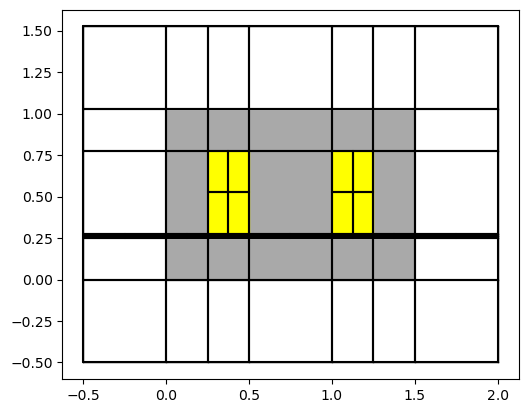

------------------------------------------------------
1
Number of DoFs: 1125
Energy: 0.0008384212218092091
Residual contributions took 0.47805023193359375 seconds.
Jump contributions took 0.9818110466003418 seconds.
Refinement took 0.15904903411865234 seconds
Basis setup took 0.06707262992858887 seconds
Prolongation took 0.13394379615783691 seconds


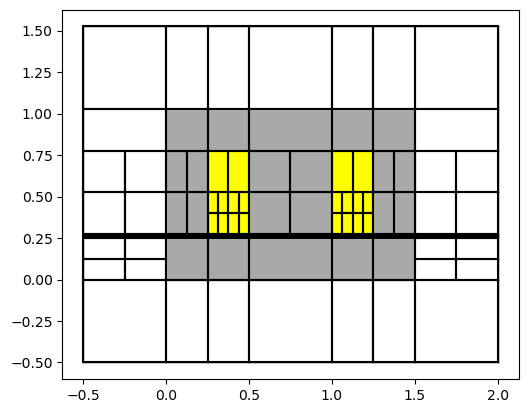

------------------------------------------------------
2
Number of DoFs: 1985
Energy: 0.000856660371308465
Residual contributions took 0.7961554527282715 seconds.
Jump contributions took 1.8764002323150635 seconds.
Refinement took 0.36002182960510254 seconds
Basis setup took 0.11438822746276855 seconds
Prolongation took 0.1950521469116211 seconds


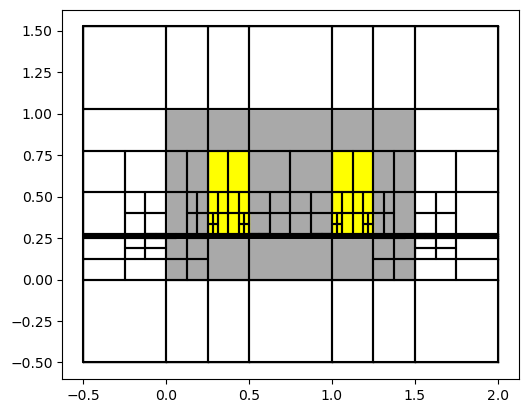

------------------------------------------------------
3
Number of DoFs: 3221
Energy: 0.0008687722056413158
Residual contributions took 1.464592456817627 seconds.
Jump contributions took 3.4861717224121094 seconds.
Refinement took 0.560741662979126 seconds
Basis setup took 0.1674196720123291 seconds
Prolongation took 0.22202420234680176 seconds


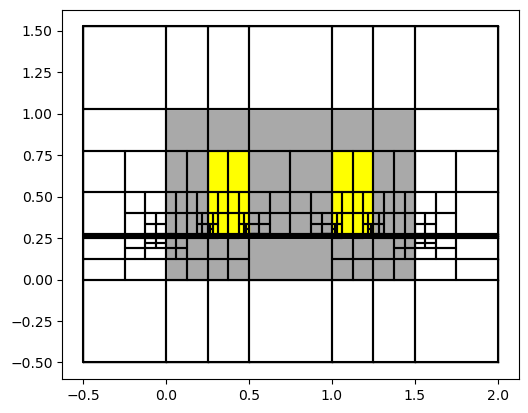

------------------------------------------------------
4
Number of DoFs: 4633
Energy: 0.0008754843568348886
Residual contributions took 1.912036418914795 seconds.
Jump contributions took 4.87741494178772 seconds.
Refinement took 0.901822566986084 seconds
Basis setup took 0.208632230758667 seconds
Prolongation took 0.26500988006591797 seconds


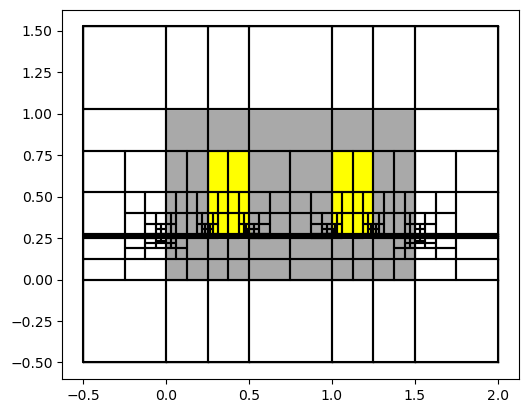

------------------------------------------------------
5
Number of DoFs: 6261
Energy: 0.0008789471047938764
Residual contributions took 2.591043472290039 seconds.
Jump contributions took 6.7374608516693115 seconds.
Refinement took 1.5126302242279053 seconds
Basis setup took 0.30391359329223633 seconds
Prolongation took 0.3411235809326172 seconds


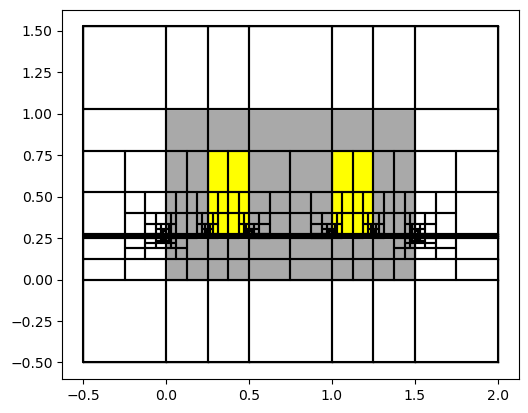

------------------------------------------------------
6
Number of DoFs: 8377
Energy: 0.0008807904496370311
Basis setup took 0.5338199138641357 seconds
Prolongation took 1.0189502239227295 seconds
------------------------------------------------------
7
Number of DoFs: 26314
Energy: 0.000881702656425576


In [11]:
deg=2
M_a=Inductor(deg,deg+1)
MP_a = assemble.Multipatch(M_a, automatch=True)
uh_a=[]
P_a=[]
err_ind=[]
Eh_a=np.zeros(maxiter)

maxiter=8
numdofs_a =np.zeros(maxiter)
err_est=np.zeros(maxiter)

for i in range(maxiter):
    print('------------------------------------------------------')
    print(i)
    bcs = MP_a.compute_dirichlet_bcs({0:0.})
    Ah_a = sum([MP_a.assemble_volume(vform.stiffness_vf(2,a=nu[k]),domain_id=k) for k in nu])
    F = sum([MP_a.assemble_volume('j * v * dx', arity=1, domain_id=k, j=j[k], physical=True) for k in j],axis=0)
    Kh_a = MP_a.assemble_volume(vform.stiffness_vf(2))
    Mh_a = MP_a.assemble_volume(vform.mass_vf(2))

    LS = assemble.RestrictedLinearSystem(Ah_a, F, bcs)
    uh_a.append(LS.complete((cholesky(LS.A.tocsc()))(LS.b)))
    Eh_a[i]=MP_a.integrate('0.5 * nu * inner(grad(uh),grad(uh)) * v * dx', u_=uh_a[-1], nu=nu)*0.0254
    print('Number of DoFs: ' + str(MP_a.numdofs))
    print('Energy: ' + str(Eh_a[i]))
    numdofs_a[i]=MP_a.numdofs
    
    if i < maxiter-2 :
        err_ind.append(adap.PoissonEstimator(MP_a, uh_a[-1], f=j, a=nu, M=MaT))
        err_est[i] = norm(err_ind[-1])
        marked_patches = adap.doerfler_marking(err_ind[-1], 0.9)
        marked_patches = {p:None for p in marked_patches}
        P_a.append(MP_a.h_refine(h_ref=marked_patches, return_P=True))
        MP_a.mesh.draw(color={'C1':'yellow', 'C2':'yellow','Fe':'darkgrey','Air':'white'})
        plt.show()
    elif i == maxiter-2:
        P_a.append(MP_a.p_refine(p_inc=1, return_P=True))
    else:
        pass
    
for k in reversed(range(1,len(P_a))):
    P_a[k-1]=P_a[k]@P_a[k-1]
    
L2err_a = np.zeros(maxiter-1)
H1err_a = np.zeros(maxiter-1)
Aherr_a = np.zeros(maxiter-1)
Eherr_a = np.zeros(maxiter-1)
for i in range(len(uh_a)-1):
    eh = P_a[i]@uh_a[i]-uh_a[-1]
    L2err_a[i] = eh @ Mh_a @ eh
    H1err_a[i] = eh @ Kh_a @ eh + L2err_a[-1]
    Aherr_a[i] = eh @ Ah_a @ eh
    Eherr_a[i]=abs(E[-1]-E[i])
    
L2err_a = sqrt(L2err_a)
H1err_a = sqrt(H1err_a)
Aherr_a = sqrt(Aherr_a)

#np.savetxt('Mp'+str(deg)+'n'+str(deg+1)+'.txt', np.c_[[numdofs_a,H1err_a,L2err_a,Aherr_a]])

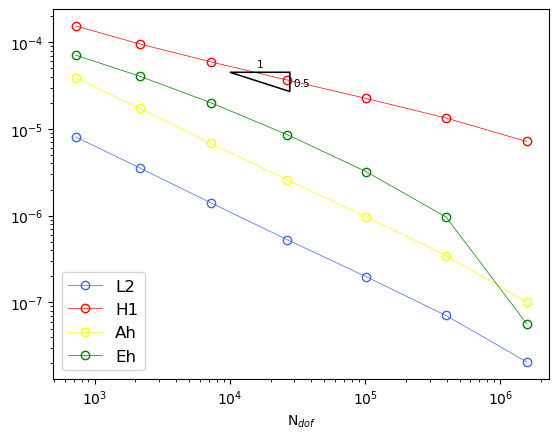

In [46]:
deg=2
fig, ax = plt.subplots()
plt.loglog(numdofs[:-1], L2err, 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs[:-1], H1err, 'o-',color='red',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs[:-1], Aherr**2*0.0254, 'o-',color='yellow',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs[:-1], Eherr, 'o-',color='green',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs[:-1], H1err[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')
plt.legend(['L2','H1','Ah','Eh'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")
#draw_loglog_slope(fig,ax,(8*1e4,0.4*1e-7),2,1.5 ,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(1e4,0.45*1e-4),2,0.5,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
plt.show()

# fig, ax = plt.subplots()
# plt.loglog(numdofs_a[:-1], L2err_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
# #plt.loglog(numdofs[:-1], L2err[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')
# plt.legend(['adaptively refined mesh','uniformly refined mesh'],loc='lower left',prop={'size': 12})
# plt.xlabel("N$_{dof}$")
# #draw_loglog_slope(fig,ax,(8*1e4,1.8*1e-7),2,4 if (deg+1)%2==0 else (deg+1)/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
# draw_loglog_slope(fig,ax,(1e4,8*1e-7),2,0.66,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
# plt.show()

In [20]:
Eerr

array([6.99408e-05, 3.97206e-05, 1.91405e-05, 7.74537e-06, 2.38368e-06, 1.22320e-07, 0.00000e+00])

In [16]:
Eerr

array([6.99408e-05, 3.97206e-05, 1.91405e-05, 7.74537e-06, 2.38368e-06, 1.22320e-07, 0.00000e+00])

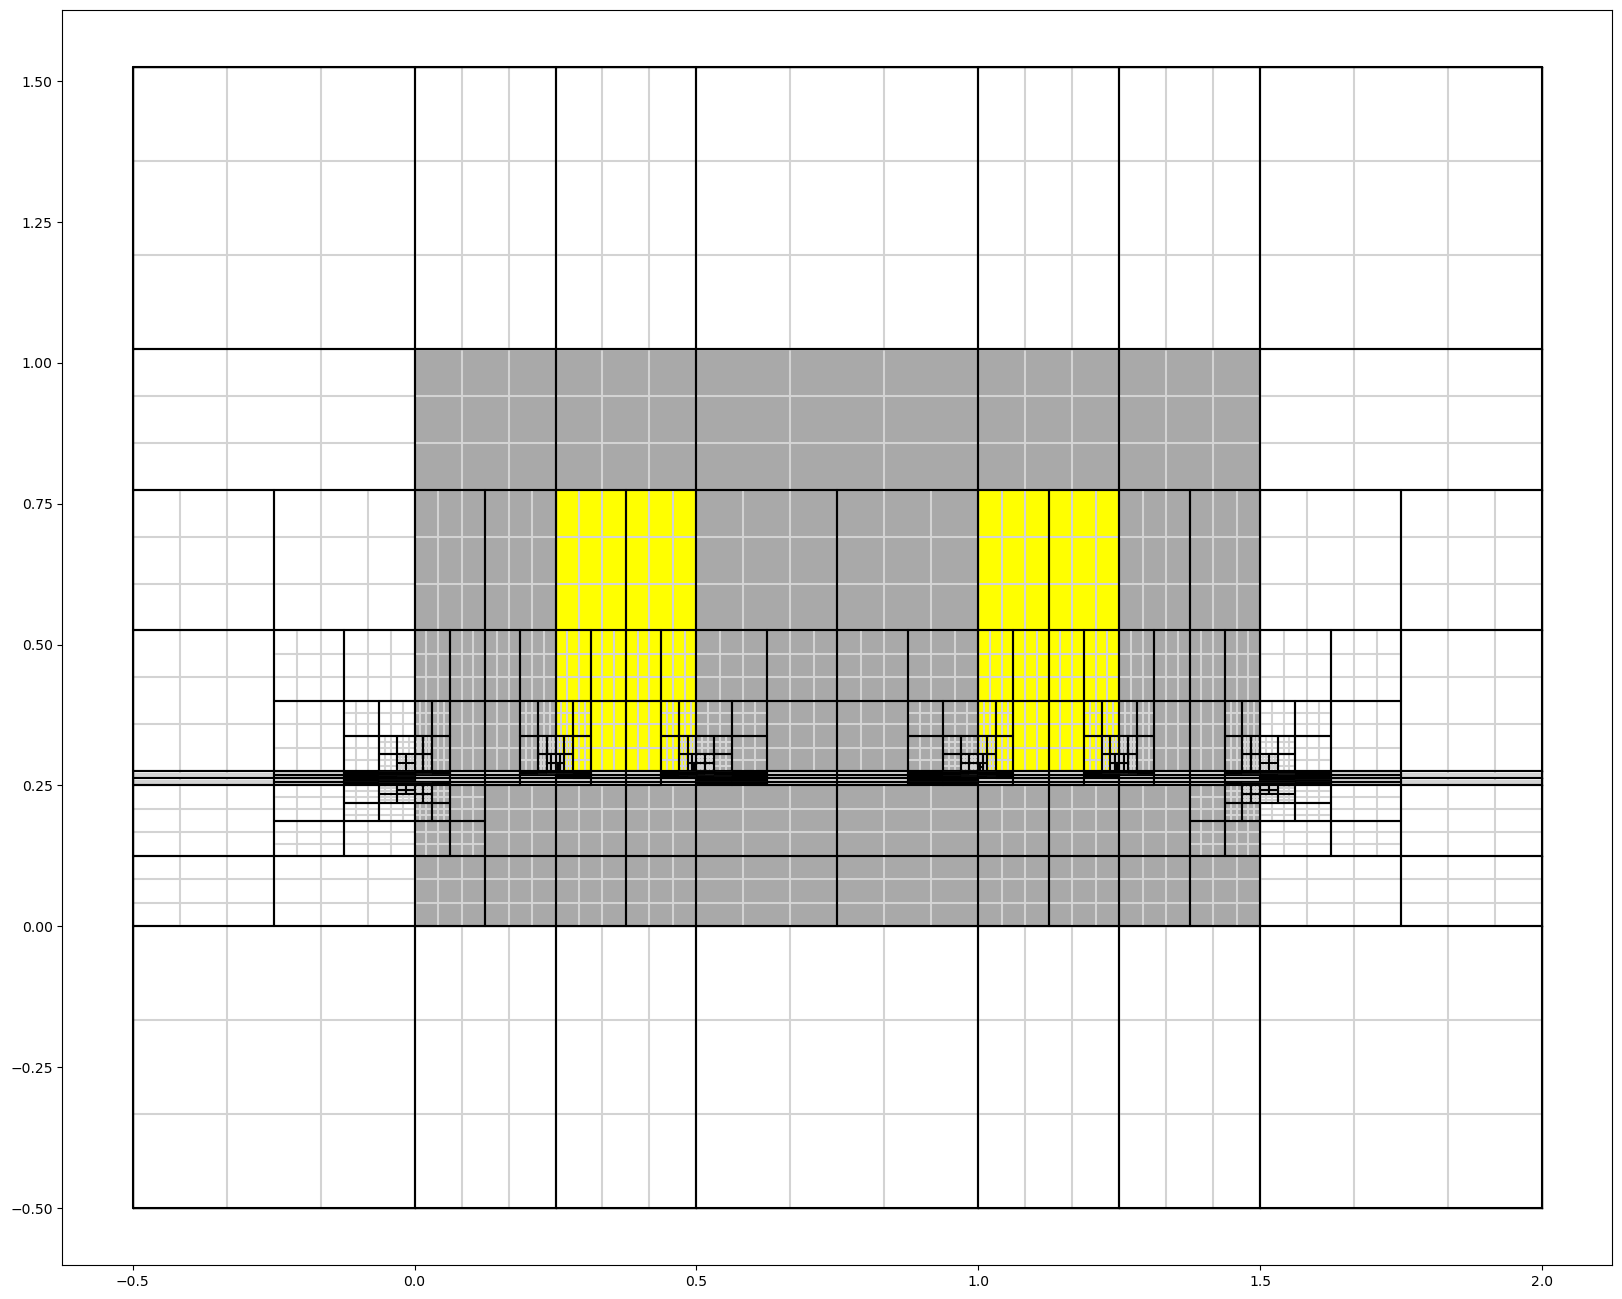

In [34]:
MP_a.mesh.draw(knots=True, color={'C1':'yellow', 'C2':'yellow','Fe':'darkgrey','Air':'white'}, figsize=(20,20))

In [ ]:
M.draw(knots=True, patch_idx=False, figsize=(10,10), color={'Air':'white', 'Fe':'darkgray', 'C1':'yellow', 'C2':'yellow'})

In [12]:
MP_a.integrate

{'Air': {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}}